# XGBoost para Clasificación
XGBoost (eXtreme Gradient Boosting) es una implementación de arboles de decisión con refuerzo de gradiente diseñada para obtener velocidad y rendimiento. Se refiere al objetivo de ingeniería de llevar al limite los recursos computacionales para algoritmos de árboles potenciados.

Con XGBoost, los árboles se construyen en paralelo, en lugar de secuencialmente como GBDT. Sigue una estrategia por niveles, explorando los valores del gradiente y utilizando estas sumas parciales para evaluar la calidad de las divisiones en cada división posible del conjunto de entrenamiento.

El refuerzo (boosting) es una técnica de conjunto en la que se añaden nuevos modelos para corregir los errores cometidos por los modelos existentes. Los modelos se añaden secuencialmente hasta que no se pueden hacer más mejoras.

El refuerzo de gradiente es una técnica donde nuevos modelos son creados para predecir los residuales o errores de modelos previos y entonces añadirlos juntos para realizar la predicción final. Es llamado refuerzo de gradiente (Gradient Boosting) porque usa un algoritmo de gradiente descendiente para minimizar la función de perdida cuando se agregan nuevos modelos. Este enfoque admite tanto problemas de modelado predictivo de regresión como de clasificación.
El término "gradient boosting" procede de la idea de "potenciar" o mejorar un único modelo débil combinándolo con otros modelos débiles para generar un modelo colectivamente fuerte. El refuerzo de gradiente es una extensión del refuerzo en la que el proceso de generación aditiva de modelos débiles se formaliza como un algoritmo de descenso de gradiente sobre una función objetivo. El refuerzo de gradiente establece los resultados objetivo para el siguiente modelo en un esfuerzo por minimizar los errores. Los resultados deseados para cada caso se basan en el gradiente del error (de ahí el nombre de refuerzo de gradiente) con respecto a la predicción.

Los GBDT entrenan de forma iterativa un conjunto de árboles de decisión poco profundos, y cada iteración utiliza los residuos de error del modelo anterior para ajustar el siguiente modelo. La predicción final es una suma ponderada de todas las predicciones de los árboles. El "bagging" de Random Forest minimiza la varianza y el exceso de ajuste, mientras que el "boosting" del GBDT minimiza el sesgo y el infraajuste.

Una pequeña lista de beneficios y atributos de XGBoost incluye los siguientes:
-	Es un proyecto de código abierto donde científicos de datos alrededor del mundo están aportando activamente.
-	Es usado en un amplio rango de aplicaciones incluyendo regresión, clasificación, retos de predicción definidos por el usuario, etc.
-	Es una librería altamente portable, actualmente se puede utilizar en Linux, Windows, OS X.
-	Es una librería creada desde cero pensando en la eficiencia, flexibilidad y portabilidad.

Las tareas de aprendizaje automático con XGBoost pueden tardar horas en ejecutarse en máquinas basadas en CPUs. Esto es porque obtener resultados altamente precisos, predicciones comparables con el estado del arte, involucra la generación de miles de arboles de decisión y las pruebas de un gran número de combinaciones de parámetros. Las unidades procesadoras de gráficos (GPU) con su arquitectura masivamente paralela, la cual consiste de miles de pequeños núcleos eficientes, puede correr miles de hilos simultáneamente en paralelo para sobrecargar las tareas de computación intensivas.


En este tutorial vamos a aprender cómo usar XGBoost para tareas de clasificación. Específicamente utilizaremos el conjunto de datos del reto en Kaggle de clasificación de productos del grupo Otto (https://www.kaggle.com/c/otto-group-product-classification-challenge).  Este conjunto de datos consiste de 93 características numéricas y 9 clases de productos diferentes. El conjunto de datos de entrenamiento tiene aproximadamente 62000 ejemplos, la única tarea de preprocesamiento que se debe aplicar a este conjunto de datos es la codificación del objetivo de texto a entero.

El objetivo es hacer predicciones de nuevos productos como un arreglo de probabilidades para cada una de las 9 categorías. Los modelos son evaluados usando multiclass logaritmic loss -también llamado entropía cruzada-.

Veamos como con XGBoost logramos resultados competitivos con relativa facilidad. Primero vamos a importar todas las librerías que necesitamos para realizar la tarea de clasificación.

In [1]:
import numpy as np
from pandas import read_csv
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, log_loss

import matplotlib.pyplot as plt

Vamos a leer el archivo csv que hemos descargado previamente de Kaggle, la primera columna del archivo no es de nuestro interés, ya que es simplemente el índice de los ejemplos. La eliminamos del conjunto de datos, posteriormente tomamos los registros de las características y de la salida aparte.

Nos interesa observar como están distribuidos los ejemplos dentro de cada clase. Hacemos una gráfica de barras, donde podemos evidenciar como hay un número alto de ejemplos para las clases 2 y 6, mientras que para las clases 7, 5, 4 y 1 el número de ejemplos es aproximadamente 6 veces menor que los de las clases dominantes.

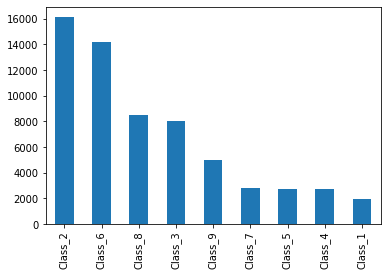

In [2]:
data = read_csv('train.csv')

data.drop("id", axis=1, inplace=True)

dataset = data.values

#data.info(verbose=True)
#data.describe()

X = dataset[:,0:-1]
Y = label_encoded_y = LabelEncoder().fit_transform(dataset[:,-1])

ax = data.target.value_counts().plot.bar()
plt.show()

## Modelo Referencia
Utilizando la clase Label Encoder de Scikit Learn realizamos la codificación de la salida de nuestros datos. Una vez ejecutada esta línea, la salida no tendrá un formato “Class_1, Class_2, etc.” si no que será codificada en enteros desde 0 hasta 8. Para utilizar XGBoost no es necesario que la salida multiclase tenga codificación one-hot.

Realizaremos la división en datos de entrenamiento y pruebas, con una proporción 70:30. Definiremos una semilla para tener repetibilidad en la división de los datos.

In [ ]:
#%% Baseline
# split data into train and test sets
seed = 7
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)


Primero vamos a entrenar un modelo XGBClassifier con los parámetros por defecto, para tener un punto de referencia. En este caso, se tendrán 100 arboles de decisión, una profundidad de aprendizaje máxima de 6 y una tasa de aprendizaje de 0,3. 

In [ ]:
# fit model on training data
model = XGBClassifier()
model.fit(X_train, y_train)

print(model)

Luego de realizar el entrenamiento del modelo definido. Luego con los datos de pruebas hacemos las predicciones en dos sentidos, primero extraemos solo la clase a la cual pertenece el ejemplo, es decir un vector donde nos indicará el número de la clase a la cual se ajusta el ejemplo. Con esta salida calcularemos el accuracy del modelo entrenado.

La siguiente predicción se realiza obteniendo las probabilidades de pertenencia a cada una de las clases de ejemplo. Es decir, un vector del tamaño del número de clases de salida, donde nos indicará la probabilidad de que el ejemplo especificado pertenezca a cada una de las clases de salida. Con esta información obtenemos la métrica de multiclass logaritmic loss.

Teniendo este modelo como referencia, posteriormente sintonizaremos algunos parámetros del modelo. Específicamente el número máximo de arboles de decisión y la tasa de aprendizaje del algoritmo.


In [ ]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions  = model.predict_proba(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
loss = log_loss(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Test logloss: {}".format(loss))

## Sintonizando Algunos Parámetros
Creamos un objeto de la clase XGBClassifier. Definimos dos listas, una para realizar variaciones sobre el número de árboles de decisión y la otra para realizar variaciones sobre la tasa de aprendizaje.

Best: -0.504334 using {'learning_rate': 0.2, 'n_estimators': 200}


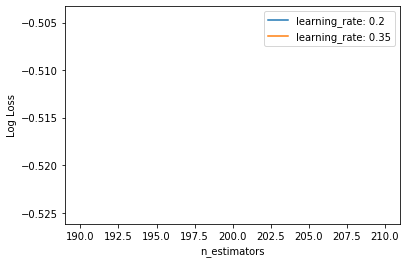

In [4]:
#%% Mejorando algunos parametros

xgb = XGBClassifier()

#n_estimators = [200, 300, 350]
#learning_rate = [0.1, 0.2, 0.35]

n_estimators = [200]
learning_rate = [0.2, 0.35]

Definimos un objeto de la clase Stratified K-Fold, utilizaremos la validación cruzada estratificada con el objetivo de que en los subconjuntos de entrenamiento y pruebas se conserve el porcentaje de ejemplos por cada clase. Como pudimos ver anteriormente las clases están desbalanceadas. En este mismo objeto también definimos el número de entrenamientos que se realizarán por cada variación, elegiremos 5 para acelerar el proceso de entrenamiento. Para intentar tener repetibilidad en el ejercicio, utilizamos una semilla para generar los números pseudoaleatorios.

In [ ]:
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=7)


Definimos la búsqueda en grilla y entrenamos los modelos en todas sus variaciones. En este caso se entrenarán en total: $ # variaciones de arboles X # variaciones de aprendizaje X # de entrenamientos $, para el ejemplo de 3X3X5 = 45 entrenamientos en total.

Imprimimos en la pantalla los parámetros con los cuales obtuvimos los mejores resultados. Si revisamos los puntajes de la competición de Kaggle podemos verificar como de forma relativamente sencilla de implementar alcanzamos resultados competitivos.

In [ ]:
grid_search = GridSearchCV(xgb, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, Y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']

Finalmente, realizamos una gráfica donde mostramos el rendimiento de los modelos entrenados con respecto al número de arboles de decisión, tomando como parámetro la tasa de aprendizaje.

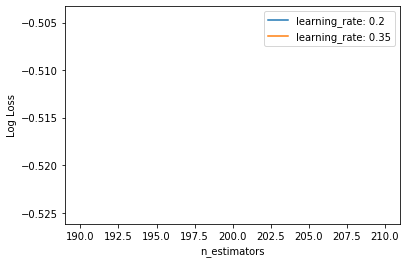

In [5]:
# plot results
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.savefig('n_estimators_vs_learning_rate.png')